Scanning files...
🏁 Benchmark will run on 500 files.
Starting Legacy Method (Full DOM Parsing)...
Legacy Duration: 15.5270 sec
Starting Turbo Method (Staging + Parquet Write)...
Turbo Duration : 7.6430 sec

RESULT: Turbo mode is 2.03x FASTER!


C:\Users\Boccaccio\AppData\Local\Temp\ipykernel_10040\571936760.py:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Method', y='Seconds', data=df_res, palette=['#95a5a6', '#e74c3c'])


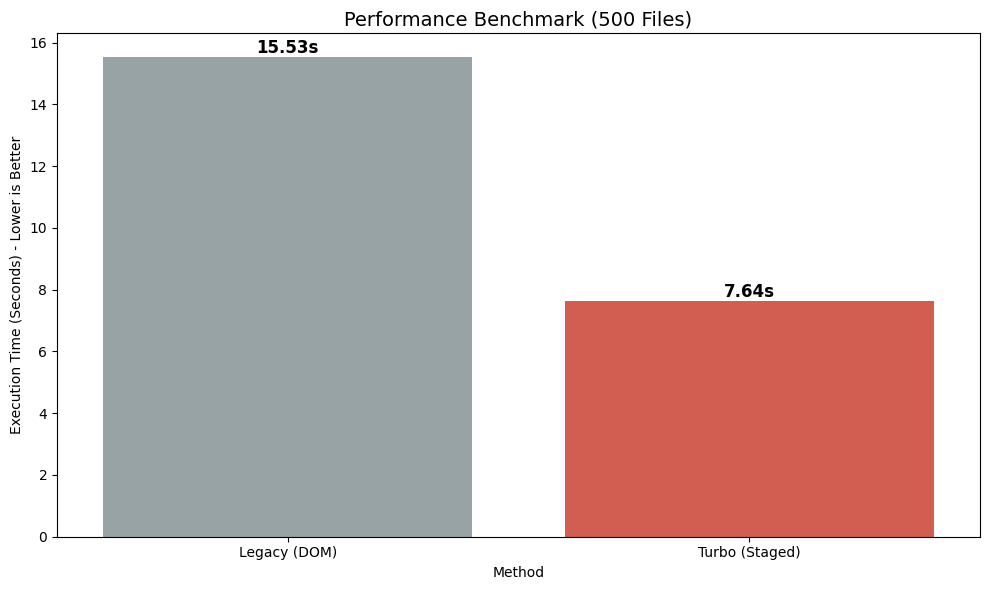

In [1]:
import time
import os
import shutil
import tempfile
import pathlib
import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import pyarrow as pa
import pyarrow.parquet as pq

# ==========================================
# CONFIGURATION
# ==========================================
# Enter the path to your TOSEC DAT files here
ROOT_DIR = r"E:\HOME\RetroVault\TOSEC_DATs\Extracted\TOSEC-v2025-03-13"
LIMIT_FILES = 500  # 500 files are sufficient for a significant benchmark

# ==========================================
# HELPER FUNCTIONS (FOR TURBO MODE)
# ==========================================
def _try_parse_size(size_str):
    """Simple size converter helper."""
    if not size_str: return 0
    try:
        return int(size_str)
    except:
        return 0

def _write_chunk_arrow(buffer, output_dir, dat_filename, chunk_index, schema):
    """Writes the buffer to disk using PyArrow (Parquet format)."""
    if not buffer: return
    try:
        table = pa.Table.from_pylist(buffer, schema=schema)
        out_name = f"{dat_filename}_{chunk_index}.parquet"
        out_path = os.path.join(output_dir, out_name)
        pq.write_table(table, out_path, compression='SNAPPY')
    except Exception as e:
        pass

def parse_and_save_chunks(file_path: str, output_dir: str, chunk_size: int = 500000):
    """
    CORE LOGIC: Reads XML in a staging fashion and writes directly to Parquet.
    Zero Pandas dependency, optimized for low memory usage.
    """
    dat_filename = os.path.basename(file_path)
    
    # Simple format check
    if not file_path.lower().endswith(('.xml', '.dat')):
        return # Skip non-xml files

    try:
        system_name = os.path.basename(os.path.dirname(file_path))
    except:
        system_name = "Unknown"
    
    platform = dat_filename.split(' - ')[0]

    buffer = []
    chunk_index = 0
    total_roms = 0
    
    # PyArrow Schema Definition
    schema = pa.schema([('filename', pa.string()), 
                        ('platform', pa.string()), 
                        ('game_name', pa.string()),
                        ('description', pa.string()), 
                        ('rom_name', pa.string()), 
                        ('size', pa.int64()),
                        ('crc', pa.string()), 
                        ('md5', pa.string()), 
                        ('sha1', pa.string()), 
                        ('status', pa.string()), 
                        ('system', pa.string())
    ])
    
    try:
        context = ET.iterparse(file_path, events=("end",))
        
        for event, elem in context:
            if elem.tag in ('game', 'machine'):
                game_name = elem.get('name')
                desc_node = elem.find('description')
                description = desc_node.text if desc_node is not None else ""
                
                for rom in elem.findall('rom'):
                    final_size = _try_parse_size(rom.get('size'))
                    
                    row = {
                        'filename': dat_filename,
                        'platform': platform,
                        'game_name': game_name,
                        'description': description,
                        'rom_name': rom.get('name'),
                        'size': final_size,
                        'crc': rom.get('crc'),
                        'md5': rom.get('md5'),
                        'sha1': rom.get('sha1'),
                        'status': rom.get('status', 'good'),
                        'system': system_name
                    }
                    buffer.append(row)
                    total_roms += 1
                
                # MEMORY CLEANUP (CRITICAL PART)
                # Clears the element from RAM immediately after processing
                elem.clear()
                
                if len(buffer) >= chunk_size:
                    _write_chunk_arrow(buffer, output_dir, dat_filename, chunk_index, schema)
                    buffer = [] 
                    chunk_index += 1
        
        # Write remaining records in buffer
        if buffer:
            _write_chunk_arrow(buffer, output_dir, dat_filename, chunk_index, schema)
            
    except Exception as e:
        # Prevent benchmark from crashing on a single bad file
        pass 

# ==========================================
# CONTENDER 1: LEGACY METHOD
# ==========================================
def benchmark_legacy_python(file_list):
    
    print(f"Starting Legacy Method (Full DOM Parsing)...")
    start_time = time.time()
    file_count = 0
    
    for full_path in file_list:
        try:
            # Legacy method loads the entire file tree into RAM
            tree = ET.parse(full_path)
            root_xml = tree.getroot()
            # Access header to simulate processing
            _ = root_xml.find("header")
            file_count += 1
        except:
            pass
            
    end_time = time.time()
    return end_time - start_time

# ==========================================
# CONTENDER 2: TURBO MODE (YOUR CODE)
# ==========================================
def benchmark_turbo_staging(file_list):
    
    print(f"Starting Turbo Method (Staging + Parquet Write)...")
    
    # Create a temporary directory (Auto-deleted after test)
    # This simulates real-world disk I/O without cluttering your drive
    with tempfile.TemporaryDirectory() as temp_dir:
        start_time = time.time()
        file_count = 0
        
        for full_path in file_list:
            parse_and_save_chunks(str(full_path), temp_dir)
            file_count += 1
            
        end_time = time.time()
        
    return end_time - start_time

# ==========================================
# THE RACE
# ==========================================

# 1. Prepare File List
print("Scanning files...")
all_files = list(pathlib.Path(ROOT_DIR).rglob("*.dat"))
if not all_files:
    # Try XML if DAT not found
    all_files = list(pathlib.Path(ROOT_DIR).rglob("*.xml"))

# Apply Limit
target_files = all_files[:LIMIT_FILES]
print(f"🏁 Benchmark will run on {len(target_files)} files.")

if len(target_files) > 0:
    # 2. Run Legacy
    time_legacy = benchmark_legacy_python(target_files)
    print(f"Legacy Duration: {time_legacy:.4f} sec")

    # 3. Run Turbo
    time_turbo = benchmark_turbo_staging(target_files)
    print(f"Turbo Duration : {time_turbo:.4f} sec")

    # 4. Calculate Speedup
    if time_turbo > 0:
        speedup = time_legacy / time_turbo
        print(f"\nRESULT: Turbo mode is {speedup:.2f}x FASTER!")
    else:
        print("\nTurbo mode finished instantly (0 seconds)!")

    # 5. Visualization
    df_res = pd.DataFrame({
        'Method': ['Legacy (DOM)', 'Turbo (Staged)'],
        'Seconds': [time_legacy, time_turbo]
    })

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Method', y='Seconds', data=df_res, palette=['#95a5a6', '#e74c3c'])
    plt.title(f"Performance Benchmark ({len(target_files)} Files)", fontsize=14)
    plt.ylabel("Execution Time (Seconds) - Lower is Better")
    
    # Annotate bars with values
    for i, v in enumerate(df_res['Seconds']):
        plt.text(i, v, f"{v:.2f}s", ha='center', va='bottom', fontweight='bold', fontsize=12)
        
    plt.tight_layout()
    plt.show()
else:
    print("Error: No files found. Please check ROOT_DIR.")